In [4]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Bayesian modeling
import pymc as pm
import arviz as az

# Make plots look clean
plt.style.use("seaborn-v0_8")

print("Libraries loaded successfully.")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


Libraries loaded successfully.


In [2]:
# Load Brent oil data
df = pd.read_csv("../data/raw/BrentOilPrices.csv")

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Sort by date (important)
df = df.sort_values("Date")

df.head()

C:\Users\deres\AppData\Local\Temp\ipykernel_10448\11028006.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


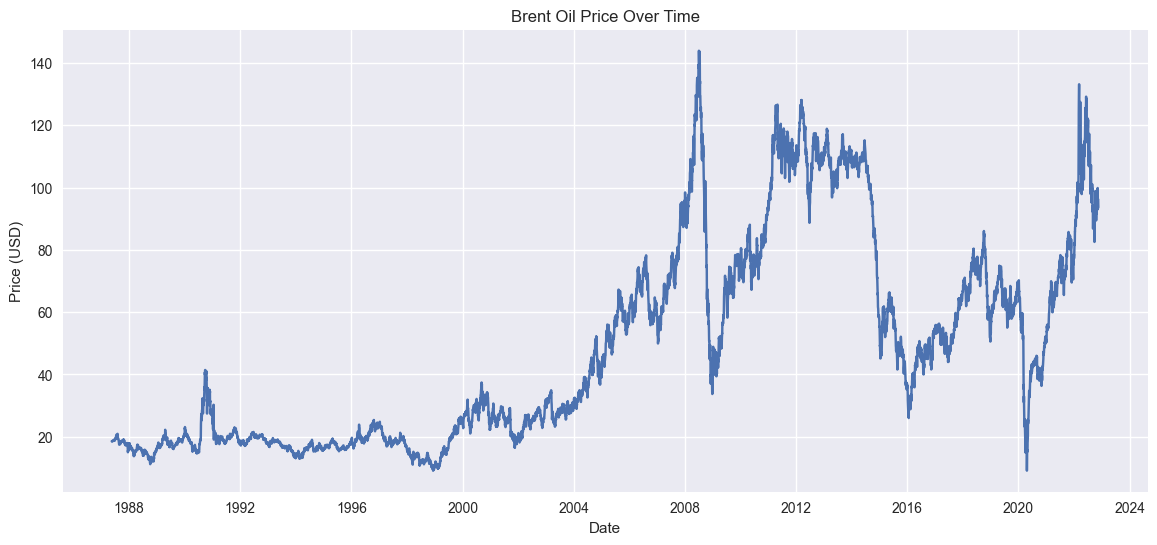

In [3]:
plt.figure(figsize=(14,6))
plt.plot(df["Date"], df["Price"])
plt.title("Brent Oil Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

In [4]:
df["log_price"] = np.log(df["Price"])
df["log_return"] = df["log_price"].diff()

df = df.dropna()

df.head()

,Date,Price,log_price,log_return
1,1987-05-21,18.45,2.915064,-0.009709
2,1987-05-22,18.55,2.920470,0.005405
3,1987-05-25,18.60,2.923162,0.002692
4,1987-05-26,18.63,2.924773,0.001612
5,1987-05-27,18.60,2.923162,-0.001612


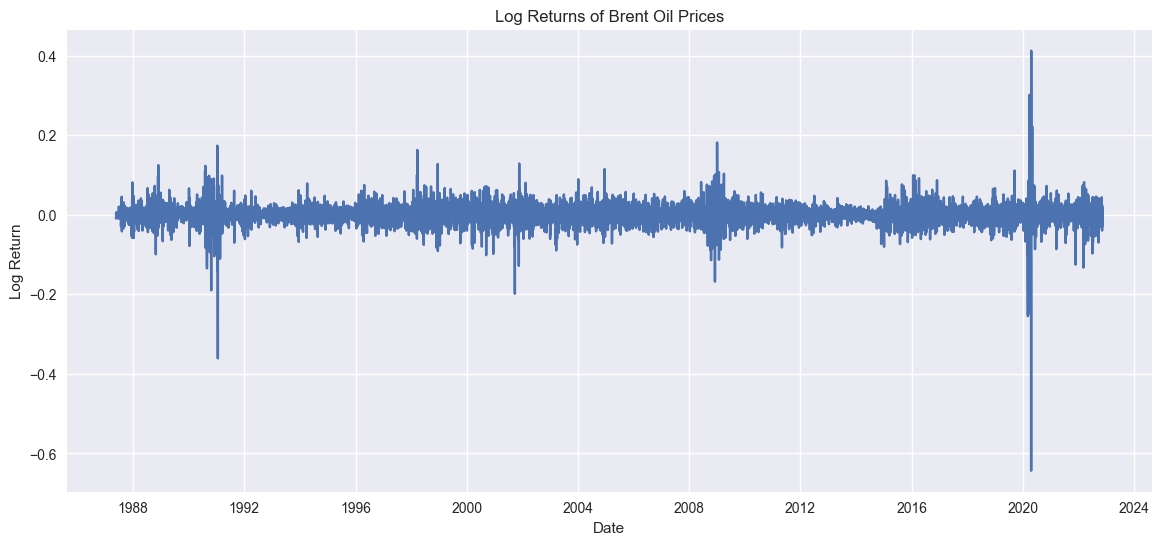

In [5]:
plt.figure(figsize=(14,6))
plt.plot(df["Date"], df["log_return"])
plt.title("Log Returns of Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

In [6]:
returns = df["log_return"].values
n = len(returns)

print("Number of observations:", n)

Number of observations: 9010


In [5]:
with pm.Model() as model:

    # Prior for change point (tau)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n-1)

    # Priors for means before and after change
    mu_1 = pm.Normal("mu_1", mu=0, sigma=1)
    mu_2 = pm.Normal("mu_2", mu=0, sigma=1)

    # Shared standard deviation
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Switch function
    mu = pm.math.switch(tau >= np.arange(n), mu_1, mu_2)

    # Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=returns)

    # Sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

NameError: name 'n' is not defined

In [1]:
az.summary(trace)

NameError: name 'az' is not defined

In [ ]:
az.plot_trace(trace)
plt.show()

In [2]:
tau_samples = trace.posterior["tau"].values.flatten()

plt.figure(figsize=(10,5))
plt.hist(tau_samples, bins=50)
plt.title("Posterior Distribution of Change Point (tau)")
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.show()

NameError: name 'trace' is not defined

In [ ]:
change_index = int(np.mean(tau_samples))
change_date = df["Date"].iloc[change_index]

print("Estimated Change Point Date:", change_date)

In [ ]:
mu1_mean = trace.posterior["mu_1"].mean().values
mu2_mean = trace.posterior["mu_2"].mean().values

print("Mean before change:", mu1_mean)
print("Mean after change:", mu2_mean)

In [ ]:
impact_percent = (mu2_mean - mu1_mean) * 100
print("Approximate percentage change in log returns:", impact_percent, "%")